# Introduction

This competition is hosted by a large grocery company in Ecuador called "Corporacion Favorita" where the aim of the game is to accurately predict and forecast the unit sales for items sold at various Favorita supermarket chains across Ecuador. Apart from the usual training and test data files provided, there are also quite a handful of other supplementary data files (5 extra files to be exact) provided to us. 

This notebook aims to take a deep-dive analysis into each of the files provided in this competition and to investigate what types of insights or observations can be derived from each. The structure of this analysis is as follows:

**1. Data loading and inspection** - Loading the data as Python dataframes and conducting data quality checks

**2. Supplementary Data exploration** - Exploration of all 5 supplementary files with a mix of D3.js visualizations and stacked barplots

**3. Training data exploration **

**4. Feature ranking with learning models** - Training a 

In [1]:
# Importing the relevant libraries
import IPython.display
import json
import pandas as pd
import seaborn as sns
import squarify
%matplotlib inline
import missingno as msno
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import numpy as np
from scipy.fftpack import fft
from matplotlib import pyplot as plt
# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template


# 1. Data loading and inspection checks

To start off with, let us load in the various supplementary comma-separated value files with the Pandas package via the the read_csv function as follows. Borrowing from Inversion's very helpful kernel in creating a dataframe with all [Date-Store_Item combinations](https://www.kaggle.com/inversion/dataframe-with-all-date-store-item-combinations) (please do check it out ), I will load in the training data using some of his methods as well. 

In [2]:
items = pd.read_csv("../input/items.csv")
holiday_events = pd.read_csv("../input/holidays_events.csv")
stores = pd.read_csv("../input/stores.csv")
oil = pd.read_csv("../input/oil.csv")
transactions = pd.read_csv("../input/transactions.csv",parse_dates=['date'])
# I read in the full training data just to get prior information and here is the output:
# Output: "125,497,040 rows | 6 columns"
train = pd.read_csv("../input/train.csv", nrows=6000000, parse_dates=['date'])

With regards to the training data, it contains a whooping 125,497,040 rows (and 6 columns). Therefore I will only load in 6 million rows of the training data (approx 5% of the data) just to get a rough idea of what is in store for us. 

In [3]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


Taking a peek, we note that the training data only consists of 6 rather measly columns and coupled with the fact that we have approx 125 million rows, there does seem to be a discrepancy in the number of features that we are going to provide our learning model to train on. However that's where the other supplementary files comes in to play as we will most definitely have to join the fields "store_nbr" (store number) and "item_nbr" as well as dates ( bring in daily oil prices). So there is actually quite a lot of potential and avenues for feature enhancement and engineering.

### NULL or missing values check

One standard check I like to carry out is to simply inspect all our data for any Null or missing values. If there are any, then we might have to think of strategies to handle them (eg. Imputation, removal of nulls etc). A good library to conveniently visualise missing values is via the "missingno" package as an aside. 

In [4]:
print("Nulls in Oil columns: {0} => {1}".format(oil.columns.values,oil.isnull().any().values))
print("="*70)
print("Nulls in holiday_events columns: {0} => {1}".format(holiday_events.columns.values,holiday_events.isnull().any().values))
print("="*70)
print("Nulls in stores columns: {0} => {1}".format(stores.columns.values,stores.isnull().any().values))
print("="*70)
print("Nulls in transactions columns: {0} => {1}".format(transactions.columns.values,transactions.isnull().any().values))

Nulls in Oil columns: ['date' 'dcoilwtico'] => [False  True]
Nulls in holiday_events columns: ['date' 'type' 'locale' 'locale_name' 'description' 'transferred'] => [False False False False False False]
Nulls in stores columns: ['store_nbr' 'city' 'state' 'type' 'cluster'] => [False False False False False]
Nulls in transactions columns: ['date' 'store_nbr' 'transactions'] => [False False False]


As we can see,  the only missing data occurs in the oil data file, which provides the historical daily price for oil. 

# 2. Supplementary Data Exploration

## 2a. Oil data

First up we can take a look at the "oil.csv" provided to us. As alluded to in section 1, this file contains daily oil prices within a time range that covers both the train and test data timeframe so this is something to note should one's learning model take into account the trend in these oil prices. This supplementary oil data seems to be a very simple two column table with one column being the date and the other the daily oil price "dcoilwtico" which seems to be the abbreviation for [Crude oil prices: West Texas Intermediate - Cushing, Oklahoma](https://fred.stlouisfed.org/series/DCOILWTICO). 



In [5]:
oil.head(3)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


**Interactive Visualisations with Plotly**

Let us take a look at the underlying data by plotting the daily oil prices in a time series plot via the interactive Python visualisation library Plot.ly as follows. Here we invoke the Plot.ly scatter plot function by calling "Scatter" and it is a simple matter of providing the date range in the x-axis and the corresponding daily oil prices in the y-axis ( as an aside I have also simultaneously dropped nulls by calling dropna( ) in the oil dataframe). I've hidden the Plot.ly code as it can get quite long so unhide it if you want to see the syntax.

In [6]:
# trace = go.Scatter(
#     name='Oil prices',
#     x=oil['date'],
#     y=oil['dcoilwtico'].dropna(),
#     mode='lines',
#     line=dict(color='rgb(20, 15, 200, 0.8)'),
#     #fillcolor='rgba(68, 68, 68, 0.3)',
#     fillcolor='rgba(0, 0, 216, 0.3)',
#     fill='tonexty' )

# data = [trace]

# layout = go.Layout(
#     yaxis=dict(title='Daily Oil price'),
#     title='Daily oil prices from Jan 2013 till July 2017',
#     showlegend = False)
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='pandas-time-series-error-bars')

#### *[THE ABOVE PLOT IS INTERACTIVE SO YOU CAN DRAG AND ZOOM ON IT. DOUBLE-CLICK TO GET BACK TO THE ORIGINAL SIZE]*

**Takeaway from the plots**

This plot shows that the daily oil price is on a general downward trend from Jan 2013 till July 2017. Where the price of oil started out 2013 by increasing and even busting the 100 dollar mark for a good few months in 2013 and 2014, it reached the middle of 2014 where there was a drastic drop in the price of oil. Via some quick open-source research (i.e Googling), this trend checks out as it seems oil prices were kept fairly stable from 2010 till mid-2014 after which it drastically fell ( due to a confluence of reasons such as weak demand due to poor economic growth and surging alternative sources of crude oil from shale/tar sands).


## 2b. Stores data

With regards to the "stores.csv" file, the data dictionary on the Kaggle competition simply states that it contains metadata on the city, state, the store type and a column termed "cluster". Now this cluster column is a grouping to stores that are similar to each other and as we can see from the latter analysis, there are a total of 17 distinct clusters. With regards to the number of stores, there are a total of 54 stores (based off a unique list of store_nbr) and therefore I presume that all the unit sales and transactions are generated off the data collected from these 54 stores.

In [7]:
stores.head(3)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


**Treemap plots of store attributes**

Treemap plots inspired from I, Coder's kernel: [Novice to Grandmaster](https://www.kaggle.com/ash316/novice-to-grandmaster)


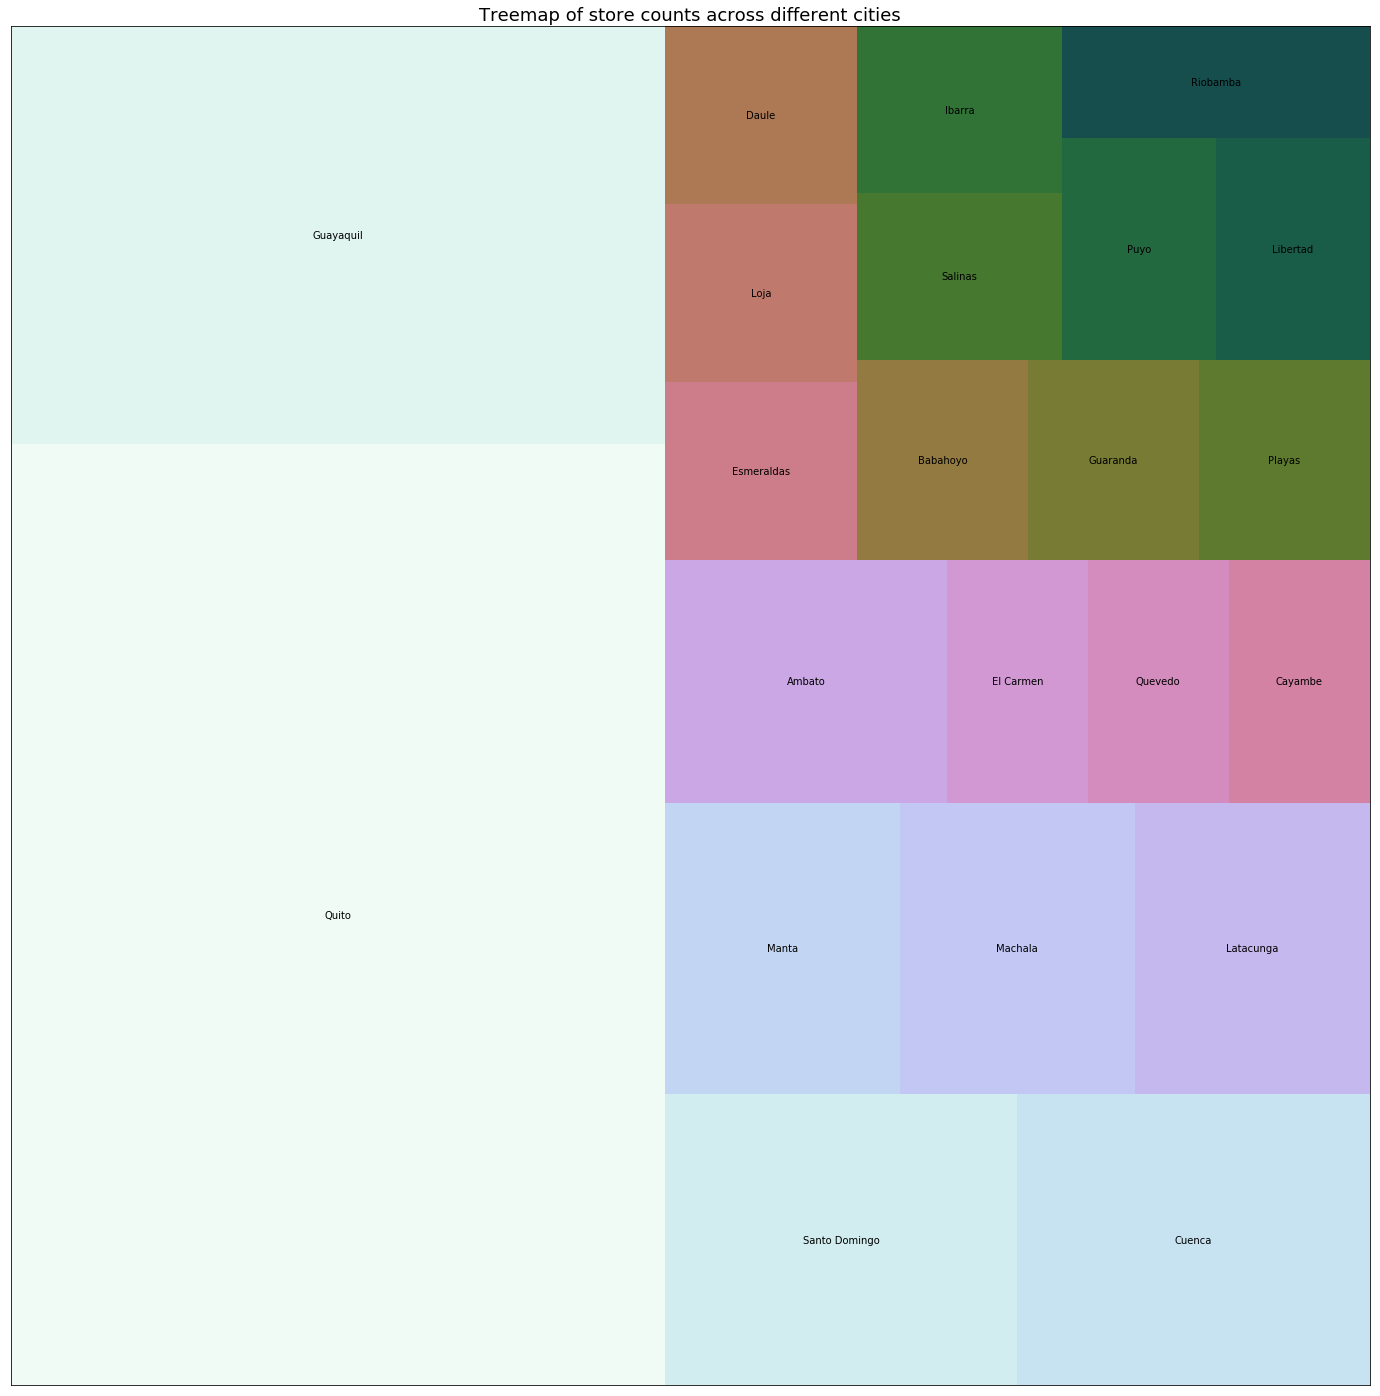

In [8]:
fig = plt.figure(figsize=(25, 21))
marrimeko=stores.city.value_counts().to_frame()
ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(sizes=marrimeko['city'].values,label=marrimeko.index,
              color=sns.color_palette('cubehelix_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig=plt.gcf()
fig.set_size_inches(40,25)
plt.title("Treemap of store counts across different cities", fontsize=18)
plt.show();

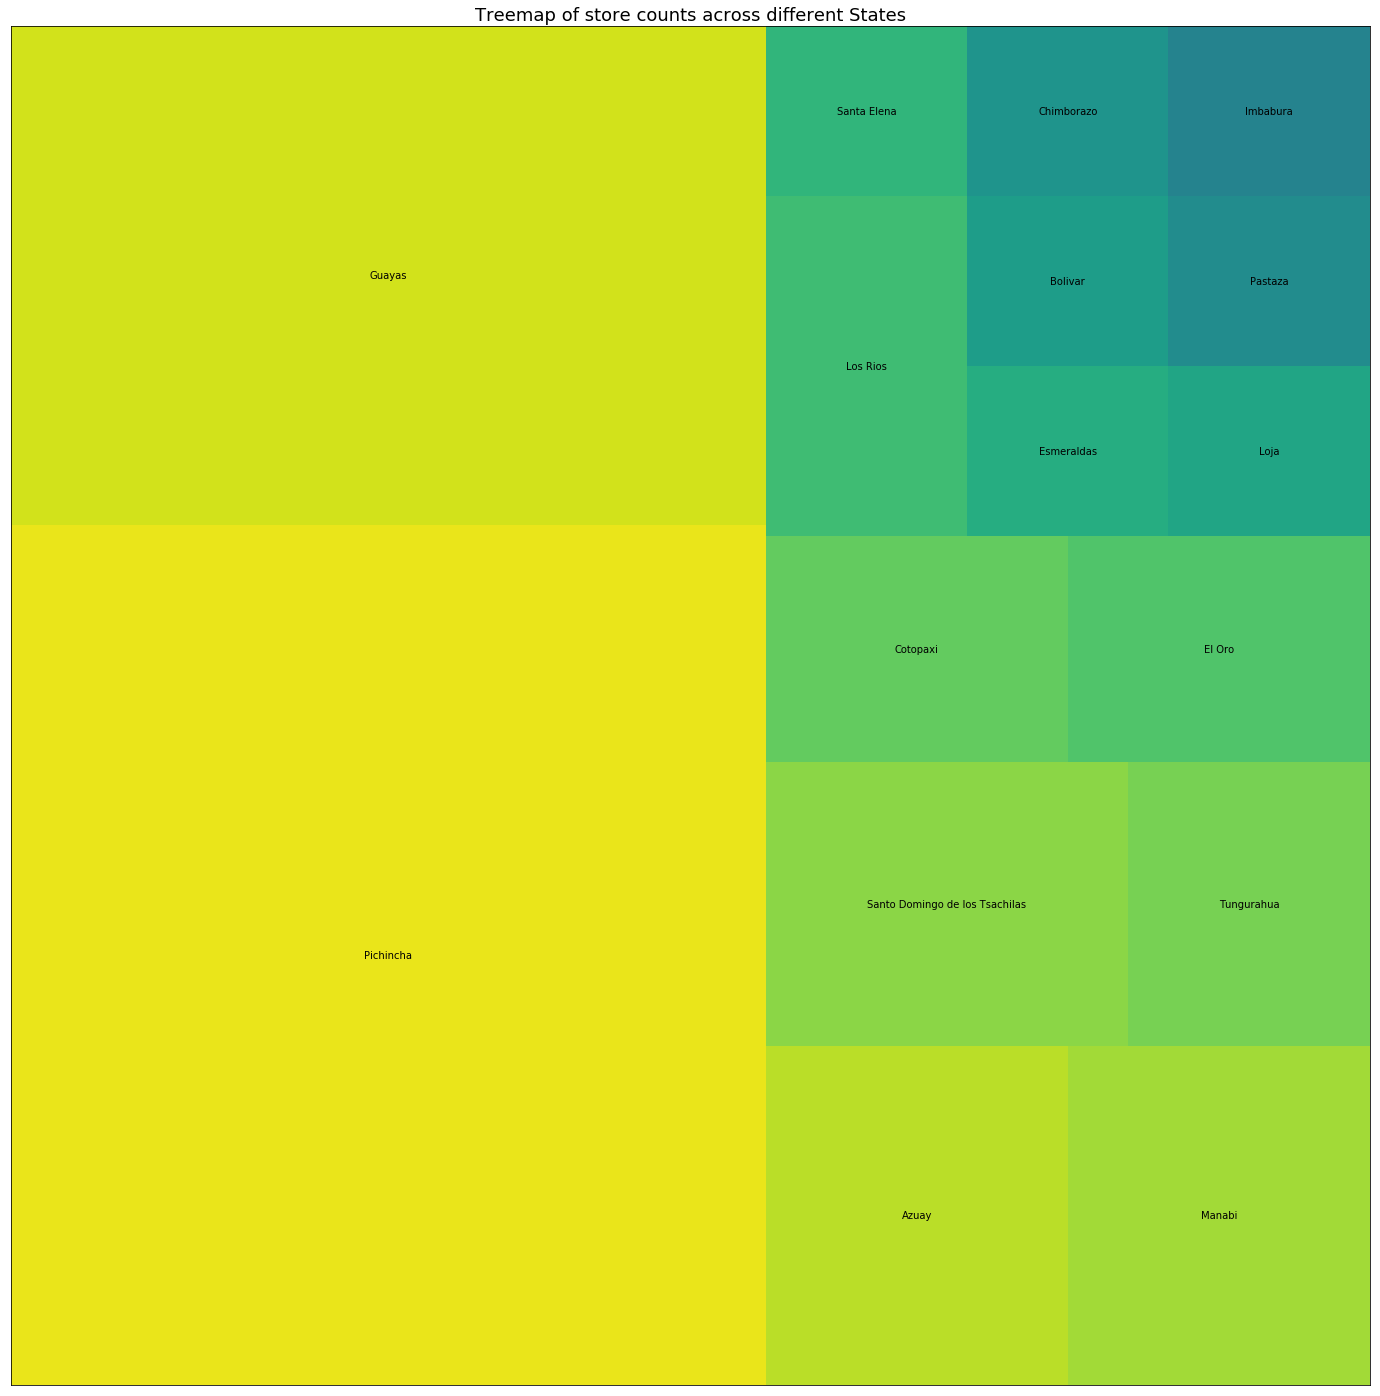

In [9]:
fig = plt.figure(figsize=(25, 21))
marrimeko=stores.state.value_counts().to_frame()
ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(sizes=marrimeko['state'].values,label=marrimeko.index,
              color=sns.color_palette('viridis_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig=plt.gcf()
fig.set_size_inches(40,25)
plt.title("Treemap of store counts across different States", fontsize=18)
plt.show()

In [10]:
stores.state.unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

**Inspecting the allocation of clusters to store numbers**

We can now generate will be that of our store numbers ordered against their respective store clusters so that we can observe if there are any apparent trends or relationships in the data. To do so, I will take our stores Python dataframe and group it based on the columns "store_nbr" and "cluster" via the **groupby** and pivot statement. After which, I will unstack the grouping which means that I will pivot on the level of store_nbr index labels, returning a DataFrame having a new level of columns which are the store clusters whose inner-most level relate to the pivoted store_nbr index labels. This technique is commonly used for producing stacked barplots in Python but since we only have unique store_nbr numbers, therefore we will simply get barplots of store numbers ordered by their relevant clusters.

In [11]:
# Unhide to see the sorted zip order
neworder = [23, 24, 26, 36, 41, 15, 29, 31, 32, 34, 39, 
            53, 4, 37, 40, 43, 8, 10, 19, 20, 33, 38, 13, 
            21, 2, 6, 7, 3, 22, 25, 27, 28, 30, 35, 42, 44, 
            48, 51, 16, 0, 1, 5, 52, 45, 46, 47, 49, 9, 11, 12, 14, 18, 17, 50]

Text(0.5,1,'Store numbers and the clusters they are assigned to')

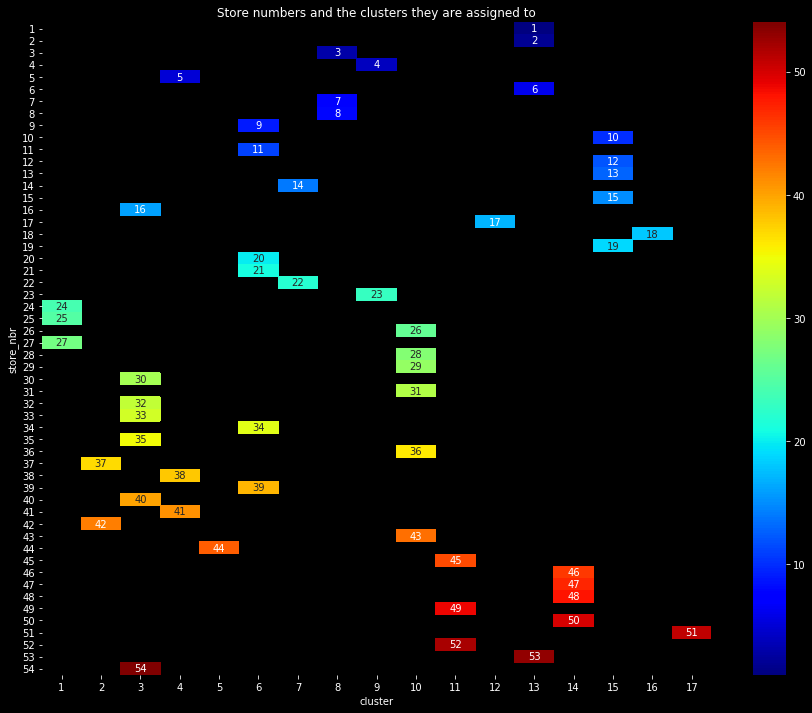

In [12]:
# Finally plot the seaborn heatmap
plt.style.use('dark_background')
plt.figure(figsize=(15,12))
store_pivot = stores.dropna().pivot("store_nbr","cluster", "store_nbr")
ax = sns.heatmap(store_pivot, cmap='jet', annot=True, linewidths=0, linecolor='white')
plt.title('Store numbers and the clusters they are assigned to')

In [13]:
# plt.style.use('dark_background')
# nbr_cluster = stores.groupby(['store_nbr','cluster']).size()
# nbr_cluster.unstack().iloc[neworder].plot(kind='bar',stacked=True, colormap= 'tab20', figsize=(13,11),  grid=False)
# plt.title('Store numbers and the clusters they are assigned to', fontsize=14)
# plt.ylabel('')
# plt.xlabel('Store number')
# plt.show()

**Takeaways from thse plot**

From visualising the store numbers side-by-side based on the clustering, we can identify certain patterns. For example clusters 3, 6, 10 and 15 are the most common store clusters based off the fact that there are more store_nbrs attributed to them then the others while on the other end of the spectrum, we have clusters 5 and 17 which are only related to the stores 44 and 51 respectively.

**Stacked Barplots of Types against clusters**

Here it might be informative to look at the distribution of clusters based on the store type to see if we can identify any apparent relationship between types and the way the company has decided to cluster the particular store. Again we apply the groupby operation but this time on type and on cluster. This time when we pivot based off this grouped operation, we are able to get counts of each distinct cluster distributed and stacked on top of other clusters per store type as follows:

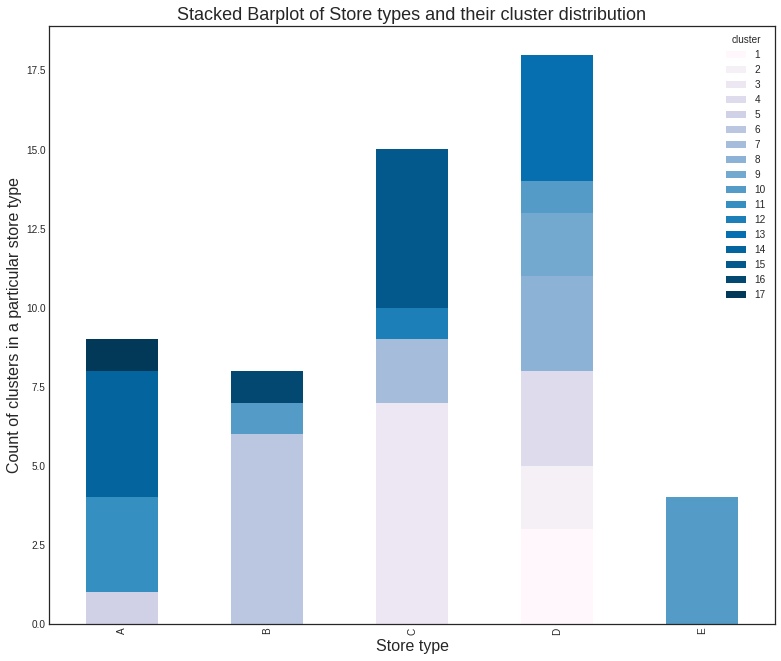

In [14]:
plt.style.use('seaborn-white')
#plt.style.use('dark_background')
type_cluster = stores.groupby(['type','cluster']).size()
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types and their cluster distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show()

**Takeaway from the plots**

Most of the store types seem to contain a mix of the clusters, especially with regards to store type "D". Only type "E" stores seem to fall within the single cluster of cluster 10. However with regards to our initial plan of trying to suss out relationships between store types and clusters, it seems that there is nothing apparent that stands out. If we think of store types, one would normally think of categories such as convenience store types, huge general store types or bulk buy types.

**Stacked barplot of types of stores across the different cities**

Another interesting distribution to observe would be the types of stores that Corporacion Favorita has decided to open for each city in Ecuador as well as the absolute number of stores for that city. All these three things can be achieved by turning to our usual groupby operation and pivoting again by unstacking and plotting as follows:

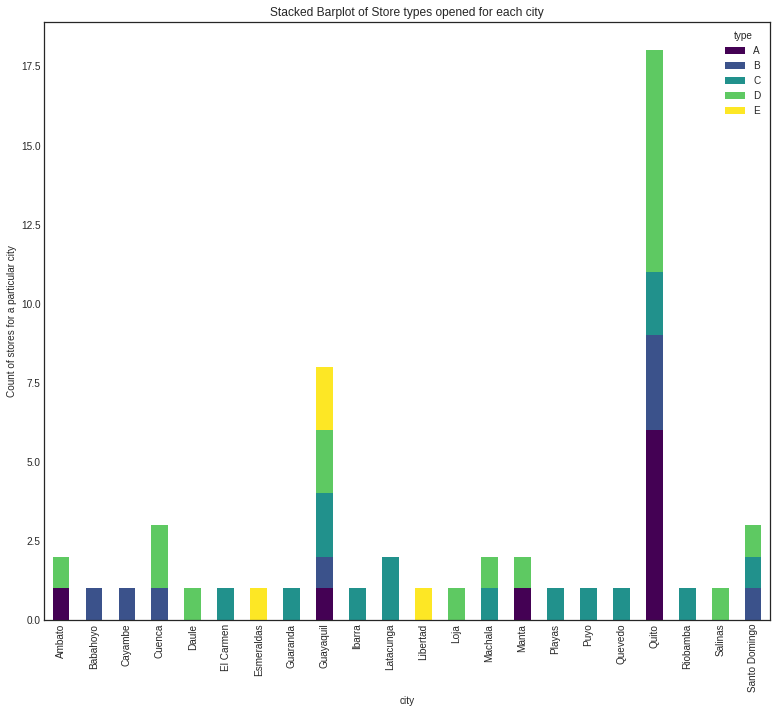

In [15]:
# plt.style.use('dark_background')
plt.style.use('seaborn-white')
city_cluster = stores.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()

**Takeaways from the plot**: 

As observed from the stacked barplots, there are two cities that standout in terms of the variety of store types on offer - Guayaquil and Quito. These should come as no surprise as [Quito](https://en.wikipedia.org/wiki/Quito) is the capital city of Ecuador while [Guayaquil](https://en.wikipedia.org/wiki/Guayaquil) is the largest and most populous city in Ecuador. Therefore one would think it logical to expect Corporacion Favorita to target these major cities with the most diverse store types probably to capture different ends of the market (if we think store types as being high-end/premium/wholesale/discount etc) as well as opening up the highest number of stores evinced from the largest counts of store_nbrs attributed to those two cities.

## 2c. Holiday Events data

Trudging on, we can inspect the "holiday_events.csv" file which contains data on the national, regional and local level of Ecuador. According to the data dictionary, we should pay special attention to the "transferred" column. 

*A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.*

In [16]:
holiday_events.head(3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


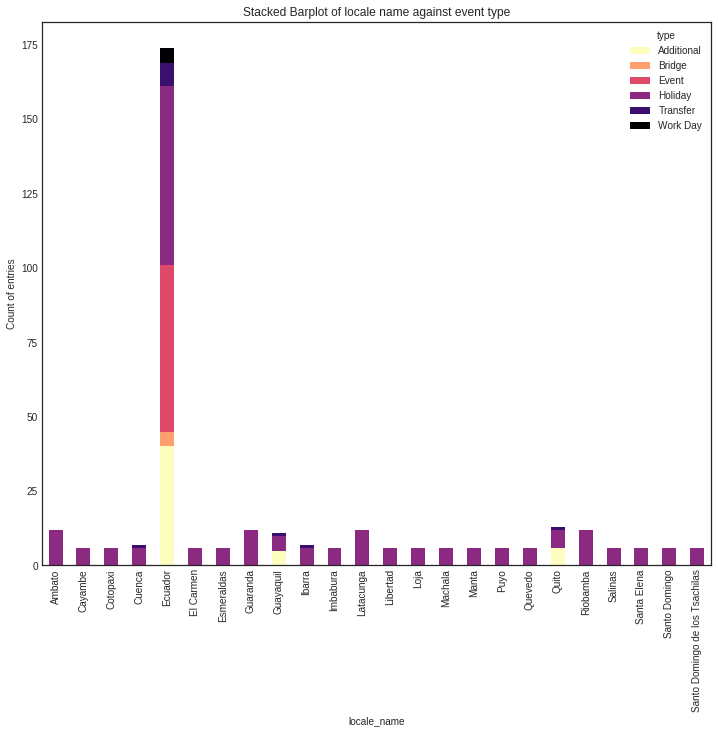

In [17]:
plt.style.use('seaborn-white')
# plt.style.use('dark_background')
holiday_local_type = holiday_events.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'magma_r', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

## D3.js Circular treemapping of Store Type to description

Next, I shall implement a circular treemap via the D3.js visualization library which allows us to intuitively visualize data and their parent clusters that they belong to. The implementation of this treemap requires quite a lot of pre-processing and kernel feature hacking and therefore I have hidden this pre-work from you in the three hidden cells below. The first hidden cell involves preparation of the json file which shall be used as the input source for our D3.js plot while the second hidden cell creates the HTML structure for our embedded visual. The third hidden cell contains embedded javascript syntax for which the the D3 circular treemap is invoked.

In [18]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     print(holiday_events[['type','description']].apply(pd.Series.value_counts))

In [19]:
# Prepping the json file
holiday_json = {
"name": "flare",
"children": [
{
"name": "Additional",
"children":[
{"name": "Batalla de Pichincha",       "size": 5.0},
{"name": "Cantonizacion de Cayambe",   "size": 6.0},
{"name": "Cantonizacion de El Carmen", "size": 6.0},
{"name": "Cantonizacion de Guaranda",  "size": 6.0},
{"name": "Cantonizacion de Latacunga", "size": 6.0},
{"name": "Cantonizacion de Libertad",  "size": 6.0},
{"name": "Cantonizacion de Quevedo",   "size": 6.0},
{"name": "Cantonizacion de Riobamba",  "size": 6.0},
{"name": "Cantonizacion de Salinas",   "size": 6.0},
{"name": "Cantonizacion del Puyo",     "size": 6.0},
{"name": "Carnaval",                   "size": 0.0},
{"name": "Dia de Difuntos",            "size": 6.0},
{"name": "Dia de la Madre",            "size": 5.0},
{"name": "Dia de la Madre-1",          "size": 5.0},
{"name": "Dia del Trabajo",             "size": 5.0},
{"name": "Fundacion de Guayaquil",    "size": 5.0},
{"name": "Fundacion de Guayaquil-1",  "size": 5.0},
{"name": "Fundacion de Quito",        "size": 6.0},
{"name": "Fundacion de Quito-1",      "size": 6.0},
{"name": "Navidad+1                                      ", "size": 6.0},
{"name": "Navidad-1                                      ", "size": 6.0},
{"name": "Navidad-2                                      ", "size": 6.0},
{"name": "Navidad-3                                      ", "size": 6.0},
{"name": "Navidad-4                                      ", "size": 6.0},
]
},
{
"name":  "Holiday",
"children":[
{"name": "Fundacion de Ambato",       "size": 6.0},
{"name": "Fundacion de Cuenca",       "size": 7.0},
{"name": "Fundacion de Esmeraldas",   "size": 6.0},
{"name": "Fundacion de Ibarra",       "size": 7.0},
{"name": "Fundacion de Loja",         "size": 6.0},
{"name": "Fundacion de Machala",      "size": 6.0},
{"name": "Fundacion de Manta",        "size": 6.0},
{"name": "Fundacion de Riobamba",     "size": 6.0},
{"name": "Fundacion de Santo Domingo", "size": 6.0}
]
},
{
"name": "Event",
"children": [
{"name": "Inauguracion Mundial de futbol Brasil          ", "size": 1.0},
{"name": "Independencia de Ambato                        ", "size": 6.0},
{"name": "Independencia de Cuenca                        ", "size": 6.0},
{"name": "Independencia de Guaranda                      ", "size": 6.0},
{"name": "Independencia de Guayaquil                     ", "size": 6.0},
{"name": "Independencia de Latacunga                     ", "size": 6.0},
{"name": "Mundial de futbol Brasil: Cuartos de Final     ", "size": 2.0},
{"name": "Mundial de futbol Brasil: Ecuador-Francia      ", "size": 1.0},
{"name": "Mundial de futbol Brasil: Ecuador-Honduras     ", "size": 1.0},
{"name": "Mundial de futbol Brasil: Ecuador-Suiza        ", "size": 1.0},
{"name": "Mundial de futbol Brasil: Final                ", "size": 1.0},
{"name": "Mundial de futbol Brasil: Octavos de Final     ", "size": 4.0},
{"name": "Mundial de futbol Brasil: Semifinales          ", "size": 2.0},
{"name": "Mundial de futbol Brasil: Tercer y cuarto lugar", "size": 1.0},
{"name": "Navidad                                        ", "size": 6.0},
{"name": "Primer Grito de Independencia                  ", "size": 6.0},
{"name": "Primer dia del ano                             ", "size": 5.0},
{"name": "Primer dia del ano-1                           ", "size": 5.0},
{"name": "Black Friday",               "size": 3.0},
{"name": "Cyber Monday",               "size": 3.0},
{"name": "Provincializacion Santa Elena                  ", "size": 6.0},
{"name": "Provincializacion de Cotopaxi                  ", "size": 6.0},
{"name": "Provincializacion de Imbabura                  ", "size": 6.0},
{"name": "Provincializacion de Santo Domingo             ", "size": 6.0},
{"name": "Terremoto Manabi                               ", "size": 1.0},
{"name": "Terremoto Manabi+1                             ", "size": 1.0},
{"name": "Terremoto Manabi+10                            ", "size": 1.0},
{"name": "Terremoto Manabi+11                            ", "size": 1.0},
{"name": "Terremoto Manabi+12                            ", "size": 1.0},
{"name": "Terremoto Manabi+13                            ", "size": 1.0},
{"name": "Terremoto Manabi+14                            ", "size": 1.0},
{"name": "Terremoto Manabi+15                            ", "size": 1.0},
{"name": "Terremoto Manabi+16                            ", "size": 1.0},
{"name": "Terremoto Manabi+17                            ", "size": 1.0},
{"name": "Terremoto Manabi+18                            ", "size": 1.0},
{"name": "Terremoto Manabi+19                            ", "size": 1.0},
{"name": "Terremoto Manabi+2                             ", "size": 1.0},
{"name": "Terremoto Manabi+20                            ", "size": 1.0},
{"name": "Terremoto Manabi+21                            ", "size": 1.0},
{"name": "Terremoto Manabi+22                            ", "size": 1.0},
{"name": "Terremoto Manabi+23                            ", "size": 1.0},
{"name": "Terremoto Manabi+24                            ", "size": 1.0},
{"name": "Terremoto Manabi+25                            ", "size": 1.0},
{"name": "Terremoto Manabi+26                            ", "size": 1.0},
{"name": "Terremoto Manabi+27                            ", "size": 1.0},
{"name": "Terremoto Manabi+28                            ", "size": 1.0},
{"name": "Terremoto Manabi+29                            ", "size": 1.0},
{"name": "Terremoto Manabi+3                             ", "size": 1.0},
{"name": "Terremoto Manabi+30                            ", "size": 1.0},
{"name": "Terremoto Manabi+4                             ", "size": 1.0},
{"name": "Terremoto Manabi+5                             ", "size": 1.0},
{"name": "Terremoto Manabi+6                             ", "size": 1.0},
{"name": "Terremoto Manabi+7                             ", "size": 1.0},
{"name": "Terremoto Manabi+8                             ", "size": 1.0},
{"name": "Terremoto Manabi+9                             ", "size": 1.0}
]
},
{
"name": "Transfer",
"children":[
{"name": "Traslado Batalla de Pichincha         ", "size": 2.0},
{"name": "Traslado Fundacion de Guayaquil       ", "size": 1.0},
{"name": "Traslado Fundacion de Quito           ", "size": 1.0},
{"name": "Traslado Independencia de Guayaquil   ", "size": 3.0},
{"name": "Traslado Primer Grito de Independencia", "size": 2.0},
{"name": "Traslado Primer dia del ano           ", "size": 1.0},
{"name": "Viernes Santo                         ", "size": 5.0}
]
},
    {
"name": "Bridge",
"children":[
{"name": "Puente Dia de Difuntos                         ", "size": 1.0},
{"name": "Puente Navidad                                 ", "size": 2.0},
{"name": "Puente Primer dia del ano                      ", "size": 2.0},
]
},
{
"name": "Work Day",
"children":[
    {"name": "Recupero puente Navidad", "size": 2.0},
    {"name": "ecupero puente primer dia del ano", "size": 2.0},
    {"name": "Recupero Puente Navidad", "size": 2.0},
    {"name": "Recupero Puente Primer dia del ano", "size": 2.0},
    {"name": "Recupero Puente Dia de Difuntos", "size": 2.0}
]
}
] 
}                          

In [20]:
# dumping the holiday_events data into a json file
with open('output.json', 'w') as outfile:  
    json.dump(holiday_json, outfile)
pd.read_json('output.json').head()

#Embedding the html string
html_string = """
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node:hover {
  stroke: #000;
  stroke-width: 1.5px;
}

.node--leaf {
  fill: white;
}

.label {
  font: 11px "Helvetica Neue", Helvetica, Arial, sans-serif;
  text-anchor: middle;
  text-shadow: 0 1px 0 #fff, 1px 0 0 #fff, -1px 0 0 #fff, 0 -1px 0 #fff;
}

.label,
.node--root,
.node--leaf {
  pointer-events: none;
}

</style>
<svg width="760" height="760"></svg>
"""

In [21]:
# Finally embed the D3.js to produce the circular treemap
js_string="""
 require.config({
    paths: {
        d3: "https://d3js.org/d3.v4.min"
     }
 });

  require(["d3"], function(d3) {

   console.log(d3);

var svg = d3.select("svg"),
    margin = 20,
    diameter = +svg.attr("width"),
    g = svg.append("g").attr("transform", "translate(" + diameter / 2 + "," + diameter / 2 + ")");

var color = d3.scaleSequential(d3.interpolateViridis)
    .domain([-4, 4]);

var pack = d3.pack()
    .size([diameter - margin, diameter - margin])
    .padding(2);

d3.json("output.json", function(error, root) {
  if (error) throw error;

  root = d3.hierarchy(root)
      .sum(function(d) { return d.size; })
      .sort(function(a, b) { return b.value - a.value; });

  var focus = root,
      nodes = pack(root).descendants(),
      view;

  var circle = g.selectAll("circle")
    .data(nodes)
    .enter().append("circle")
      .attr("class", function(d) { return d.parent ? d.children ? "node" : "node node--leaf" : "node node--root"; })
      .style("fill", function(d) { return d.children ? color(d.depth) : null; })
      .on("click", function(d) { if (focus !== d) zoom(d), d3.event.stopPropagation(); });

  var text = g.selectAll("text")
    .data(nodes)
    .enter().append("text")
      .attr("class", "label")
      .style("fill-opacity", function(d) { return d.parent === root ? 1 : 0; })
      .style("display", function(d) { return d.parent === root ? "inline" : "none"; })
      .text(function(d) { return d.data.name; });

  var node = g.selectAll("circle,text");

  svg
      .style("background", color(-1))
      .on("click", function() { zoom(root); });

  zoomTo([root.x, root.y, root.r * 2 + margin]);

  function zoom(d) {
    var focus0 = focus; focus = d;

    var transition = d3.transition()
        .duration(d3.event.altKey ? 7500 : 750)
        .tween("zoom", function(d) {
          var i = d3.interpolateZoom(view, [focus.x, focus.y, focus.r * 2 + margin]);
          return function(t) { zoomTo(i(t)); };
        });

    transition.selectAll("text")
      .filter(function(d) { return d.parent === focus || this.style.display === "inline"; })
        .style("fill-opacity", function(d) { return d.parent === focus ? 1 : 0; })
        .on("start", function(d) { if (d.parent === focus) this.style.display = "inline"; })
        .on("end", function(d) { if (d.parent !== focus) this.style.display = "none"; });
  }

  function zoomTo(v) {
    var k = diameter / v[2]; view = v;
    node.attr("transform", function(d) { return "translate(" + (d.x - v[0]) * k + "," + (d.y - v[1]) * k + ")"; });
    circle.attr("r", function(d) { return d.r * k; });
  }
});
  });
 """

**Displaying the HTML and D3 visuals on IPython notebook**

Finally we invoke the following code to display the D3 visuals where I will be plotting the various descriptions/names under their parent holiday/event cluster types. The following plot is interactive and zoomable so please click onto the circles to zoom in and click anywhere outside to zoom back to the default view.

In [22]:
h = display(HTML(html_string))
j = IPython.display.Javascript(js_string)
IPython.display.display_javascript(j)

In [23]:
holiday_events.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'], dtype=object)

## 2d. Transactions data



**PERIODICITY IN TRANSACTION PATTERN**

Inspecting the transactions file, we must be aware that the transactional data is only included for the training timeframe according to the competition's data dictionary. Furthermore the columns in this file relate only to the count of sales transactions for 

In [24]:
print(transactions.head(3))
print("="*60)
print("There are {0} rows and {1} columns in the transactions data".
      format(transactions.shape[0], transactions.shape[1]))

        date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
There are 83488 rows and 3 columns in the transactions data


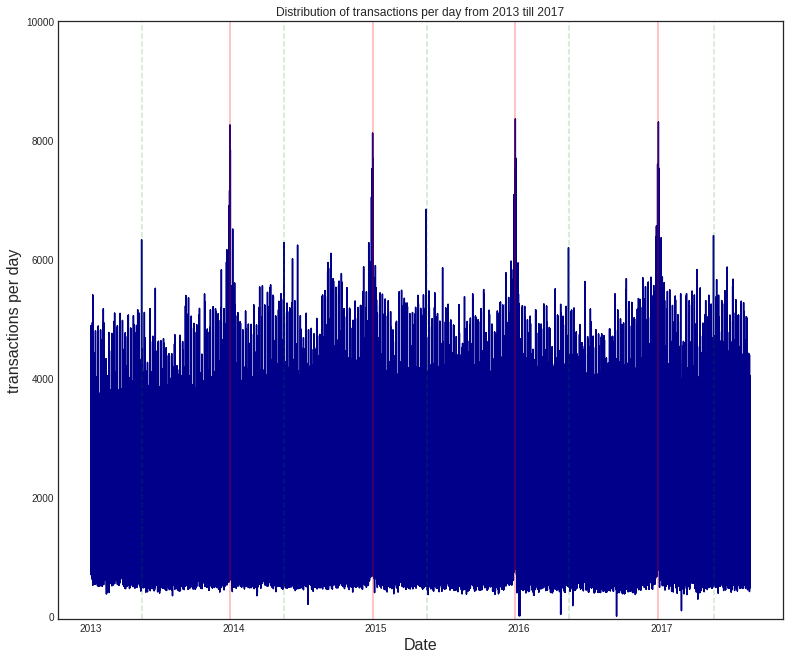

In [25]:
plt.style.use('seaborn-white')
plt.figure(figsize=(13,11))
plt.plot(transactions.date.values, transactions.transactions.values, color='darkblue')
plt.axvline(x='2015-12-23',color='red',alpha=0.3)
plt.axvline(x='2016-12-23',color='red',alpha=0.3)
plt.axvline(x='2014-12-23',color='red',alpha=0.3)
plt.axvline(x='2013-12-23',color='red',alpha=0.3)
plt.axvline(x='2013-05-12',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2015-05-10',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2016-05-08',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2014-05-11',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2017-05-14',color='green',alpha=0.2, linestyle= '--')
plt.ylim(-50, 10000)
plt.title("Distribution of transactions per day from 2013 till 2017")
plt.ylabel('transactions per day', fontsize= 16)
plt.xlabel('Date', fontsize= 16)
plt.show()

**Takeaway from the plots**

Interestingly when plotting transactions on a year-to-year basis, we can already pick out two different periodic spikes in transactions from the data (one in the solid Red line and the other the dotted Green line). The bigger yearly periodic spike in transactions seem to occur at the end of the year in December, specifically on the 23 December every year-end. Perhaps this is due to some sort of Christmas sale/discount that Corporacion Favorita holds every December thereby explaining the bump in transactions on this date. The weaker periodic spike given by the green dotted lines seems to occur around the middle of the months of May , specifically on the sunday in the second week of May. Perhaps another similar scheme is being implemented by Corporacion Favorita on those sundays.

## 2e. Items data

Moving onto the "items.csv" file, we can see that there are not many columns in the data. There is a unique item number identifier "item_nbr" which I presume relates to mappings to grocery items such as "Housebrand tomatoes pack of 6" or maybe "4 blueberry muffins" etc. The family column should be pretty self-explanatory in the sense that this relates to parent category that that particular item relates to.

In [26]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [27]:
x, y = (list(x) for x in zip(*sorted(zip(items.family.value_counts().index, 
                                         items.family.value_counts().values), 
                                        reverse = False)))
trace2 = go.Bar(
    y=items.family.value_counts().values,
    x=items.family.value_counts().index,
    marker=dict(
        color=items.family.value_counts().values,
        colorscale = 'Portland',
        reversescale = False
    ),
    orientation='v',
)

layout = dict(
    title='Counts of items per family category',
     width = 800, height = 800,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

**Takeaways from the plot**

As we can see from this barplot, the y-axis shows the counts of items while the x-axis displays the different family categories that the various retail items fall under, sorted from largest number of item counts to smallest number of items. As we can see from the plot, the top 3 family categories are the GROCERY I, BEVERAGES and CLEANING categories. 

In [28]:
x, y = (list(x) for x in zip(*sorted(zip(items['class'].value_counts().index, 
                                         items['class'].value_counts().values), 
                                        reverse = False)))
trace2 = go.Bar(
    x=items['class'].value_counts().index,
    y=items['class'].value_counts().values,
    marker=dict(
        color=items['class'].value_counts().values,
        colorscale = 'Jet',
        reversescale = True
    ),
    orientation='v',
)

layout = dict(
    title='Number of items attributed to a particular item class',
     width = 800, height = 1400,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

**Takeaways from the plot**

Plotting the count of 

In [29]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


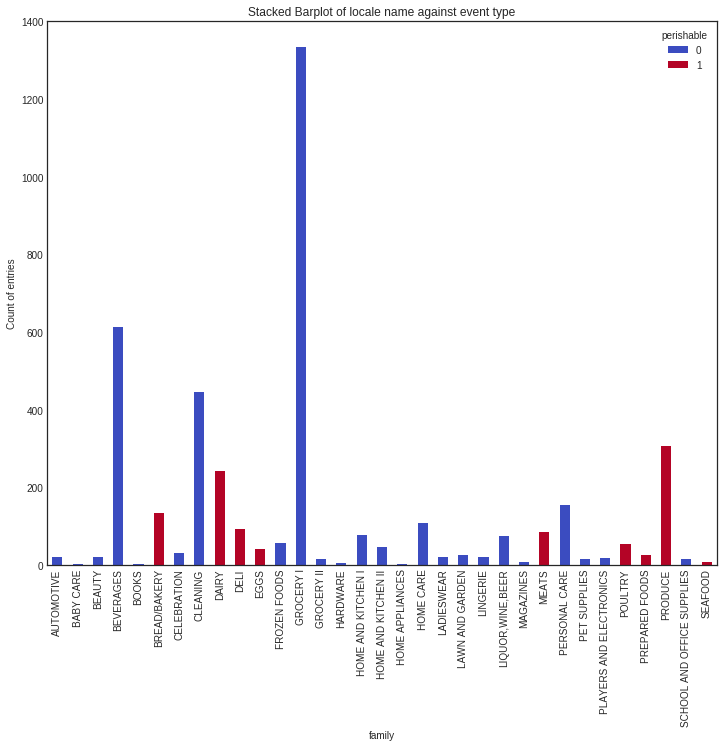

In [30]:
plt.style.use('seaborn-white')
fam_perishable = items.groupby(['family', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar',stacked=True, colormap= 'coolwarm', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

**Takeaways from the plot**



# 3. Training Data exploration

Finally we can now conduct an analysis of the training data. Since the entire training set is so large, as observed beforei

In [31]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


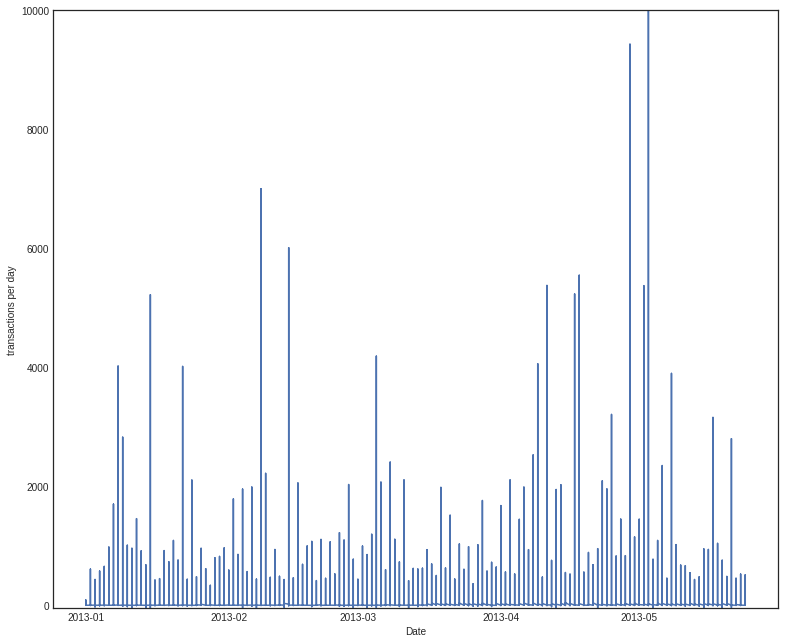

In [32]:
plt.style.use('seaborn-deep')
plt.figure(figsize=(13,11))
plt.plot(train.date.values, train.unit_sales)
plt.ylim(-50, 10000)
plt.ylabel('transactions per day')
plt.xlabel('Date')
plt.show()